# Group-wise PMF

This notebook can be used to reproduce the psychometric functions of data from Experiment 1. 

created 23.09.2021

In [1]:
# import relevant modules
import os, sys, glob
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as s
import warnings

# import specific functions/ classes
from scipy.stats import logistic
from scipy.optimize import minimize
from scipy.stats import pearsonr, spearmanr, kendalltau 
from scipy.stats import ttest_rel
from pathlib import Path

# print settings for easier df inspection
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)

# suppress Jupyter related warnings
warnings. filterwarnings("ignore")

C:\Users\annae\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\annae\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
# change into folder that contains data. For optimal functioning, 
# download data folder into ChoiceHistory_Psych folder and name it "Data"
path = os.getcwd()
p = Path(path).parents[1]
file_path = str(p) + '\\Data\\Exp1_auditory\\'
os.chdir(file_path)

# read pre-processed datafile and check how many participants are included
df = pd.read_csv('exp1_clean_pmf.csv')
subjects = list(df['sbj_id'].unique())
print('Number of included participants: ',len(subjects))
df.head()

Number of included participants:  113


,Unnamed: 0,sbj_id,trial,block_type,block,stimulus,target,response,cue,caps,pdi,resp_1,resp_2,resp_3,resp_4,resp_5,resp_6,resp_7,stim_1,stim_2,stim_3,stim_4,stim_5,stim_6,stim_7
0,0,5e6d3324f14d262fced5bbfe,1,0,1,0.4,1,1,0,5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,5e6d3324f14d262fced5bbfe,2,0,1,0.5,1,1,1,5,5,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,5e6d3324f14d262fced5bbfe,3,0,1,0.1,1,0,1,5,5,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN
3,3,5e6d3324f14d262fced5bbfe,4,0,1,0.5,1,1,1,5,5,0.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN
4,4,5e6d3324f14d262fced5bbfe,5,0,1,0.1,1,1,1,5,5,1.0,0.0,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN


In [3]:
# define a PMF
def fit_PMF(df): 
    
    choices = df.loc[:,'response'].values
    stimuli = df.loc[:,'stimulus'].values
    
    def minfun(params): 
        noise,bias = params
        cp= 1 / (1 + np.exp(-(stimuli - bias) / noise))
        model_p = cp * (choices==1) + (1-cp) * (choices==0)
        return -np.sum(np.log(np.maximum(1e-2,model_p)))
     
    noise,bias = minimize(minfun,[1,1],bounds=[(1e-2,0.4),(-10,10)]).x
    
    return bias, noise

In [4]:
choices = df.loc[:,'response'].values

In [5]:
choices

array([1, 1, 0, ..., 0, 1, 1], dtype=int64)

In [6]:
# separate datafile: repetitive and neutral conditions, onto which we fit separate PMFs. 
# we need 4 dataframes: neut_left, neut_right, rep_left, rep_right.
# neutral blocks
neut_left = df[(df['block_type']==1) & (df['resp_1']==1)]
neut_right = df[(df['block_type']==1) & (df['resp_1']==0)]
# repetitive blocks
rep_left = df[(df['block_type']==0) & (df['resp_1']==1)]
rep_right = df[(df['block_type']==0) & (df['resp_1']==0)]


# get repetitive params
bias_rep_right, noise_rep_right = fit_PMF(rep_right)
bias_rep_left, noise_rep_left = fit_PMF(rep_left)
# get neutral params
bias_neut_right, noise_neut_right = fit_PMF(neut_right)
bias_neut_left, noise_neut_left = fit_PMF(neut_left)

In [7]:
# ttest shows no significant shift in neutral cond
ttest_rel(neut_right.groupby('sbj_id').response.mean(), neut_left.groupby('sbj_id').response.mean())

Ttest_relResult(statistic=0.8444859589575713, pvalue=0.4001981690577723)

In [8]:
# ttest in repetitive condition: we have a significant shift here. 
ttest_rel(rep_right.groupby('sbj_id').response.mean(), rep_left.groupby('sbj_id').response.mean(), nan_policy='omit')

Ttest_relResult(statistic=-19.805138375322862, pvalue=2.1785846405478733e-38)

In [9]:
def plot_PMF(bias_l, noise_l, bias_r, noise_r, ax, choices_l, stimuli_l, choices_r, stimuli_r):

    x = np.arange(-1,1,0.1)
    
    # logistic func
    logis = lambda x, beta, bias: 1/(1+np.exp(-(x-bias)/beta))
    
    # gefittete oder empirical PMF fitten? 
    # Daten ohne log fit plotten und schauen: sind die Daten schon log? 
    
    # prev_left
    ax.plot(x, logis(x, noise_l, bias_l), label='previous left',color='#0A9094')
    threshold_l = np.interp(0.0, x, logis(x,noise_l,bias_l))
    
    # prev right
    ax.plot(x, logis(x, noise_r, bias_r), label='previous right',color='#D96923')
    threshold_r = np.interp(0.0, x, logis(x,noise_r,bias_r))
    
    # orienting lines
    ax.plot([0, 0], [-0.02, 1.02], 'k-', alpha=0.4)
    ax.plot([-1, 1], [0.5, 0.5], 'k-', alpha=0.4) 
    
    # plot data frequencies
    for v in [-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4,0.5,0.6]: 
        ax.plot(v, np.mean(choices_l[stimuli_l == v] == 1),'o', color='#0A9094',alpha=0.6)
        ax.plot(v, np.mean(choices_r[stimuli_r == v] == 1),'*', color='#D96923',alpha=0.6)
    
    plt.suptitle('Experiment 1', fontsize=20)
    
    plt.xlim([-1, 1]) #-0.65, 0.65 
    plt.xticks(np.arange(-1, 1, 0.5))
    ax.legend(loc='best')
    fig.show()

In [10]:
# choices and stimuli in the neutral blocks (for plotting of data frequency)
choices_l_n = neut_left.loc[:, 'response'].values   
stimuli_l_n = neut_left.loc[:, 'stimulus'].values
choices_r_n = neut_right.loc[:, 'response'].values
stimuli_r_n = neut_right.loc[:, 'stimulus'].values

# chocies and stimuli in repetitive blocks
choices_l_r = rep_left.loc[:, 'response'].values
stimuli_l_r = rep_left.loc[:, 'stimulus'].values
choices_r_r = rep_right.loc[:, 'response'].values
stimuli_r_r = rep_right.loc[:, 'stimulus'].values

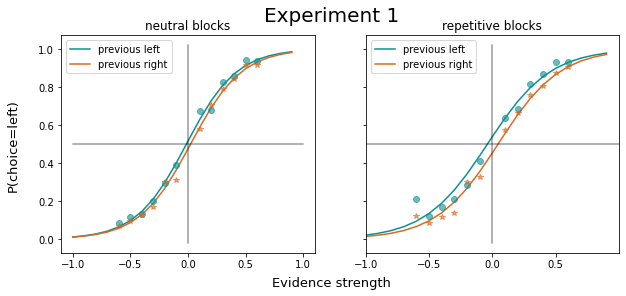

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2,sharey=True,figsize=(10,4))

plot_PMF(bias_neut_left, noise_neut_left, bias_neut_right, noise_neut_right, ax1, choices_l_n, stimuli_l_n, choices_r_n, stimuli_r_n)
ax1.title.set_text('neutral blocks')
plot_PMF(bias_rep_left, noise_rep_left, bias_rep_right, noise_rep_right, ax2, choices_l_r, stimuli_l_r, choices_r_r, stimuli_r_r)
ax2.title.set_text('repetitive blocks')

_ = fig.text(0.5,0.01, 'Evidence strength' , ha='center', fontsize=13)
_ = fig.text(0.05, 0.5, 'P(choice=left)', va='center',rotation='vertical', fontsize=13)

#save as HQ svg file
plt.savefig('C:\\Users\\annae\\Desktop\\ChoiceHistory_Psych\\revision_SB2\\pmf_groupwise_exp1.svg')